In [1]:
# Only run this cell once
import os
moduledir = os.path.dirname( os.getcwd() )

os.chdir(moduledir) # Move up one directory so we can import modules

In [2]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

from TunnelingExperiment import TunnelingExperiments

# The Issue

Here, we set up an experiment simulation as one would be expected to do.

In [3]:
d1 = 1 # nm between tip and sample
d2 = 305 # nm between backgate and sample
e1 = 1 # relative permittivity between tip and sample
e2 = 4 # relative permittivity between backgate and sample
T = 0 # Kelvin
Wtip = 5 # eV for work function of the tip

experiment = TunnelingExperiments.BLGinSTM(d1,d2,e1,e2,T,Wtip)

VTrange = [-0.2,0.2]
num_vts_100 = 1
VT = np.linspace(VTrange[0],VTrange[-1],num=int(num_vts_100*100))


VBrange = [-45,45]
num_vbs_100 = 1
VB = np.linspace(VBrange[0],VBrange[-1],num=int(num_vbs_100*100))

Next, we generate the current...

In [21]:
experiment.generate_tunnelcurrent(VTrange,num_vts_100,VBrange,num_vbs_100,method='DasSarma')

Computing tunnel currents


C:\python\lib\site-packages\scipy\integrate\quadpack.py:385: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  warnings.warn(msg, IntegrationWarning)


C:\python\lib\site-packages\scipy\integrate\quadpack.py:385: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  warnings.warn(msg, IntegrationWarning)


C:\python\lib\site-packages\scipy\integrate\quadpack.py:385: IntegrationWarning: Extremely bad integrand behavior occurs at some points of the
  integration interval.
  warnings.warn(msg, IntegrationWarning)


and plot the $dI/dV$ spectra.

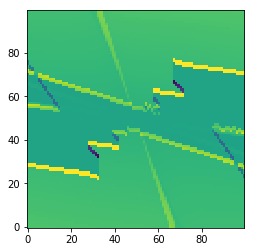

In [22]:
dIdV = np.gradient(experiment.I,axis=0)

fig, ax = plt.subplots()

ax.imshow(dIdV,vmax=10000000000000,origin='lower');

As we can see, there appear to be steps in the shadow gap.

# Step-by-step Checking

## Checking the Equilibrium voltages

The equilibrium voltages appear to be fine. They take on roughly the same values as my old algorithm.

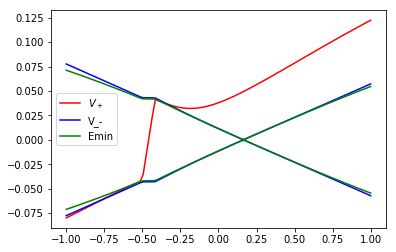

In [4]:
VT = np.linspace(-1,1,num=100)
VB = 35

experiment.plot_v_eq(VT,VB)

Are there any jumps over the range of interest?

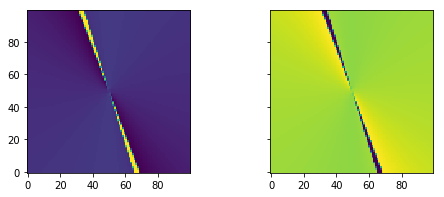

In [18]:
VT = np.linspace(-0.2,0.2,num=100)
VB = np.linspace(-45,45,num=100)[:,np.newaxis]

VP = np.empty_like(VT*VB)
VM = np.empty_like(VP)

for i in range(len(VT)):
    for j in range(len(VB)):
        VP[i,j], VM[i,j] = experiment.v_eq(VT[i],VB[j])

fig, (ax1, ax2) = plt.subplots(nrows=1,ncols=2, figsize=(8,3),sharex=True,sharey=True)
ax1.imshow(np.gradient(VP,axis=0),origin='lower')
ax2.imshow(np.gradient(VM,axis=0),origin='lower');


## The Tunnel Current

Below is the code for `tunnelcurrent`. We pass in the Fermi level $V_+$, the interlayer potential $V_-$, and the tip voltage $V_T$.

```python
def tunnelcurrent(self,vplus,vminus,VT,T):
```

The voltages are related to the *Fermi level* $\epsilon_F$ and *interlayer potential energy* $u$
```python
    eF = q*vplus
    u = -2*q*vminus
```

    # Estimate prefactor C0
    C0 = (4*pi*q / hbar) * 1 * self.BLG.Ac *1

    # Calculate the parameters we need
    phibar = self.Wtip - (q/2)*VT

    kappa0 = np.sqrt(2*m*phibar)/hbar

In [4]:
points = 200

VT = np.linspace(-1,1,num=points)
VB = -30


TC = np.empty((points,5))

for i,vt in enumerate(VT):
    vp, vm = experiment.v_eq(vt,VB)
    TC[i,:] = experiment.tunnelcurrent(vp,vm,vt,0)

C:\python\lib\site-packages\scipy\integrate\quadpack.py:385: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  warnings.warn(msg, IntegrationWarning)
C:\python\lib\site-packages\scipy\integrate\quadpack.py:385: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  warnings.warn(msg, IntegrationWarning)


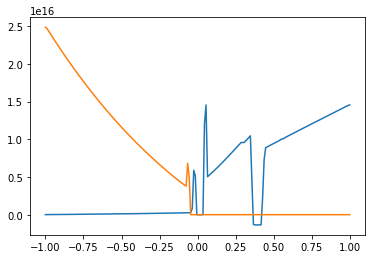

In [5]:
plt.plot(VT,np.gradient(TC[:,0],axis=0))
plt.plot(VT,np.gradient(TC[:,-1],axis=0));

The region where neither the blue curve nor the orange curve contribute must be a region where the entire integration domain is within the gap. It makes sense that this is near zero, since $V_T$ determines the width of the gapped region. Both the Fermi level and the tip energy need to be within the gap.

## Checking DOS

In [39]:
BLG.DOS??

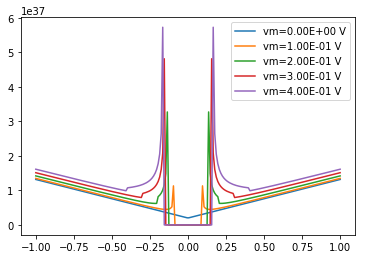

In [44]:
from UniversalConstants import *
from Materials import Graphene

BLG = Graphene.Bilayer()

es = np.linspace(-1,1,num=200)*q

us = -2*q*np.linspace(0,0.4,num=5)

for u in us:
    plt.plot(es/q,BLG.DOS(es,u),label='vm={:.2E} V'.format(u/(-2*q)))

plt.legend()
plt.show()



## Checking the Fermi-Dirac Distribution

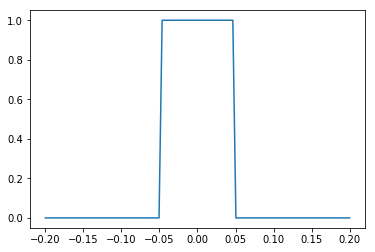

In [15]:
from StatisticalDistributions import Temperature
from UniversalConstants import q

VT = 0.1
T = 0
fermidirac = lambda x : Temperature.FermiDirac(x-0.5*q*VT,T) - Temperature.FermiDirac(x+0.5*q*VT,T)

es = np.linspace(-0.2,0.2,num=100)*q

plt.plot(es/q, fermidirac(es));

## The meat

Current is proportional to

$$ \int_{-\infty}^{\infty}\left[f\left(\epsilon-\frac{1}{2}eV_T\right)-f\left(\epsilon+\frac{1}{2}eV_T\right)\right]\rho_{BLG}\left(\epsilon_F +\frac{1}{2}eV_T+\epsilon \right)e^{\epsilon C}$$

```python
    fermidirac = lambda x : Temperature.FermiDirac(x-0.5*q*VT,T) - Temperature.FermiDirac(x+0.5*q*VT,T)
    integrand = lambda x : fermidirac(x) * self.BLG.DOS(eF+x+0.5*q*VT,u) * np.exp((x)*kappa0*self.d1/(2*phibar))

    # Points which are divergences or discontinuities or the bounds
    bounds = np.sort( np.array([u/2, -u/2, self.BLG.emin(u), -self.BLG.emin(u),10*q,-10*q]) ) 
    bounds = bounds - eF - 0.5*q*VT
    tc = np.empty(len(bounds)-1)

    for i in range(len(tc)):
        tc[i] = integrate.quad(integrand,bounds[i],bounds[i+1])[0]

    return C0 * tc.sum()

```